[ ] Fix the latent variance calculations. (I think it's just taking total variance instead of the 2 norm of z vectors.)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

In [2]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts.head()

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv
0,281474976710657,191815,1,LUM,4797.2383,550.61346,15.421524,18.445875
1,281474976710663,214084,1,SEC11C,4801.7330,905.11600,14.925031,31.019386
2,281474976710672,191342,0,TCIM,4804.4920,596.05396,14.681485,22.270780
3,281474976710673,191574,0,STC1,4805.0483,414.38370,19.306356,16.183300
4,281474976710674,192193,0,STC1,4805.7170,273.81440,16.112896,26.251837


In [3]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering.set_spot_size(100)
clustering.create_spot_data(third_dim=False, save_data=True)

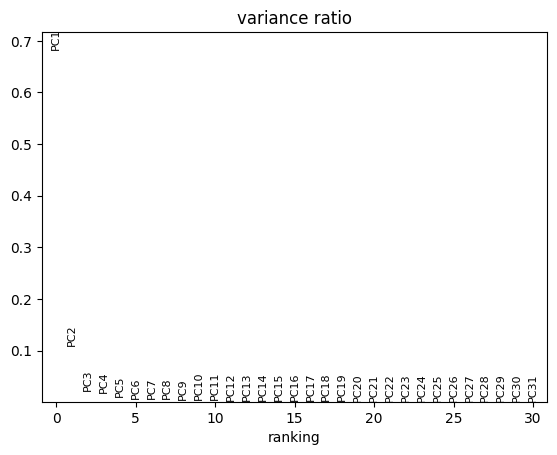

In [4]:
clustering.normalize_counts(clustering.xenium_spot_data)
clustering.filter_only_high_variable_genes(clustering.xenium_spot_data)
# generate the neigborhood graph based on pca
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack')
sc.pl.pca_variance_ratio(clustering.xenium_spot_data)

In [5]:
clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]

In [6]:
clustering.xenium_spot_data.var, clustering.xenium_spot_data.var.shape

(         highly_variable     means  dispersions  dispersions_norm
 ABCC11              True  2.953047     3.744833          1.381699
 ACTA2               True  3.785395     4.306623          0.855501
 ACTG2               True  2.702556     3.293917          0.277550
 ADH1B               True  2.189261     3.317184          1.345480
 ADIPOQ              True  1.312891     3.692371          2.333570
 ...                  ...       ...          ...               ...
 TRAF4               True  3.451874     3.772538          0.095950
 TRAPPC3             True  3.757066     3.888496         -0.408003
 TRIB1               True  2.911854     3.839642          1.613857
 TUBA4A              True  3.123837     3.380066          0.007989
 VWF                 True  2.611254     3.533479          0.757073
 
 [180 rows x 4 columns],
 (180, 4))

In [7]:
clustering.xenium_spot_data.obs, clustering.xenium_spot_data.obs.shape

(     spot_number    x_location   y_location z_location   row    col
 0             18     58.685923  1860.775855  11.995915  18.0    0.0
 1             19     48.868837  1948.936671  11.944450  19.0    0.0
 2             20     44.957070  2062.145073  11.886400  20.0    0.0
 3             21     64.296418  2135.863892  11.883457  21.0    0.0
 4             22     40.359721  2275.333869  12.084637  22.0    0.0
 ...          ...           ...          ...        ...   ...    ...
 7307        9145  10209.827800  6787.376660  24.731413  67.0  102.0
 7308        9146  10247.916375  6830.041012  24.520689  68.0  102.0
 7309        9147  10248.615000  6923.818400  24.694735  69.0  102.0
 7310        9231  10303.937000  6412.000000  24.712805  64.0  103.0
 7311        9232  10305.357000  6548.361000  24.396360  65.0  103.0
 
 [7312 rows x 6 columns],
 (7312, 6))

In [8]:
expression_data = pd.DataFrame(clustering.xenium_spot_data.X, columns=clustering.xenium_spot_data.var.index)
clustering.xenium_spot_data.obs.index = clustering.xenium_spot_data.obs.index.astype(int)
input_data = clustering.xenium_spot_data.obs.join(expression_data)
input_data.head()

,spot_number,x_location,y_location,z_location,row,col,ABCC11,ACTA2,ACTG2,ADH1B,...,TIGIT,TOP2A,TPD52,TPSAB1,TRAC,TRAF4,TRAPPC3,TRIB1,TUBA4A,VWF
0,18,58.685923,1860.775855,11.995915,18.0,0.0,0.0,0.693147,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.693147,0.0,0.0,0.0
1,19,48.868837,1948.936671,11.944450,19.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,1.098612,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,20,44.957070,2062.145073,11.886400,20.0,0.0,0.0,0.693147,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,21,64.296418,2135.863892,11.883457,21.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.693147,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,22,40.359721,2275.333869,12.084637,22.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### Reconstruction Loss

Input: $X$

Reconstruction: $X^{'}$

$$(X - X^{'})^2$$

### Spatial Loss

Left Boundary $(l)$: $\max(0, j - n)$

Right Boundary $(r)$: $\min(0, j + n)$

Top Boundary $(t)$: $\max(0, i - n)$

Bottom Boundary $(b)$: $\min(0, i + n)$

$$\frac{1}{IJ} \sum_{i=1}^I \sum_{j=1}^{J} \frac{1}{(r-l+1)(b-t+1)}\sum_{i^{'} = b}^{t} \sum_{j^{'}=l}^{r} D_{KL}(C[i^{'}, j^{'}], C[i, j]) $$

### Entropy Regularization

$$- \frac{1}{IJK} \sum_{i=1}^{I}\sum_{j=1}^{J}\sum_{k=1}^{K} p_{i,j}(k) \log(p_{i,j}(k)) $$

In [118]:
class ClassifierAutoEncoder(L.LightningModule):

    def __init__(
            self, 
            within_cluster_penalty_hyperparam = 1, 
            spatial_penalty_hyperparam = 1,
            entropy_penalty_hyperparam = 1,
            neighborhood_size = 5,
        ):

        self.within_cluster_penalty_hyperparam = within_cluster_penalty_hyperparam
        self.spatial_penalty_hyperparam = spatial_penalty_hyperparam
        self.entropy_penalty_hyperparam = entropy_penalty_hyperparam
        self.neighborhood_size = neighborhood_size

        self.loss_array = []

        super(ClassifierAutoEncoder, self).__init__()

        # think about replicate mode for padding?
        self.activation = torch.nn.LeakyReLU()
        self.enc_conv1 = torch.nn.Conv2d(in_channels=180, out_channels=90, kernel_size=5, stride=1, padding=2)
        self.enc_batchnorm1 = torch.nn.BatchNorm2d(90)
        self.enc_conv2 = torch.nn.Conv2d(in_channels=90, out_channels=45, kernel_size=5, stride=1, padding=2)
        self.enc_batchnorm2 = torch.nn.BatchNorm2d(45)
        self.enc_conv3 = torch.nn.Conv2d(in_channels=45, out_channels=15, kernel_size=5, stride=1, padding=2)
        self.enc_batchnorm3 = torch.nn.BatchNorm2d(15)

        self.dec_conv1 = torch.nn.Conv2d(in_channels=15, out_channels=45, kernel_size=5, stride=1, padding=2)
        self.dec_batchnorm1 = torch.nn.BatchNorm2d(45)
        self.dec_conv2 = torch.nn.Conv2d(in_channels=45, out_channels=90, kernel_size=5, stride=1, padding=2)
        self.dec_batchnorm2 = torch.nn.BatchNorm2d(90)
        self.dec_conv3 = torch.nn.Conv2d(in_channels=90, out_channels=180, kernel_size=5, stride=1, padding=2)
        
        self.clust_linear1 = torch.nn.Linear(15, 32)
        self.clust_linear2 = torch.nn.Linear(32, 16)
        self.clust_linear3 = torch.nn.Linear(16, 10)
        self.clust_softmax = torch.nn.Softmax(dim=1)

        self.encoder = torch.nn.Sequential(
            self.enc_conv1,
            self.enc_batchnorm1,
            self.activation,
            self.enc_conv2, 
            self.enc_batchnorm2,   
            self.activation,       
            self.enc_conv3,  
            self.enc_batchnorm3    
        )

        self.decoder = torch.nn.Sequential(
            self.dec_conv1,
            self.dec_batchnorm1,
            self.activation,
            self.dec_conv2, 
            self.dec_batchnorm2,
            self.activation,          
            self.dec_conv3, 
        )

        self.cluster_assignment = torch.nn.Sequential(
            self.clust_linear1,
            self.activation,
            self.clust_linear2,
            self.activation,
            self.clust_linear3,
            self.clust_softmax 
        )

    def training_mask(self, x):
        pass

    def training_step(self, batch, batch_idx):
        x, x_hat, z, cluster = self(batch)
        loss = self.spatial_loss_function(x, x_hat, z, cluster)
        print(round(loss.item(), 4))
        self.loss_array.append(round(loss.item(), 4))
        print(f"# of Clusters: {cluster.argmax(dim=1).unique().numel()}")
        return loss

    def validation_step(self, batch, batch_idx):
        x, x_hat, z, cluster = self(batch)
        return self.spatial_loss_function(x, x_hat, z, cluster)

    def test_step(self, batch, batch_idx):
        x, x_hat, z, cluster = self(batch)
        return self.spatial_loss_function(x, x_hat, z, cluster)

    def cluster_utilization_loss(self, cluster_probs, min_clusters=3, threshold=0.15):
        # Softmax probabilities for each cluster, across all examples
        max_probs, _ = torch.max(cluster_probs, dim=0)
        
        # Smooth approximation of the thresholding operation
        # Using sigmoid to create a soft threshold
        temperature = 10  # Temperature controls the sharpness of the transition
        used_clusters = torch.sigmoid(temperature * (max_probs - threshold))
        
        # Expected number of clusters above the threshold
        num_used_clusters = torch.sum(used_clusters)
        
        # Penalizing the fewer than minimum required clusters
        penalty = F.relu(min_clusters - num_used_clusters) ** 2
        
        return penalty


    def spatial_loss_function(self, input, reconstruction, latents, cluster_assignments):
        reconstruction_loss = F.mse_loss(input, reconstruction)
        within_cluster_penalty = self.within_cluster_average_latent_dissimilarity(latents, cluster_assignments)
        spatial_cluster_penalty = self.neighboring_cluster_dissimilarity(cluster_assignments, input)
        entropy_penalty = self.entropy_regularization(cluster_assignments, input)
        diff_clusters = self.cluster_utilization_loss(cluster_assignments)
        print(f"""LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Spatial, Entropy) 
              ({reconstruction_loss}, {self.within_cluster_penalty_hyperparam * within_cluster_penalty}, {self.spatial_penalty_hyperparam * spatial_cluster_penalty}, {self.entropy_penalty_hyperparam * entropy_penalty}, {100*diff_clusters})
              """)
        return self.within_cluster_penalty_hyperparam * within_cluster_penalty
        return reconstruction_loss + self.within_cluster_penalty_hyperparam * within_cluster_penalty + self.spatial_penalty_hyperparam * spatial_cluster_penalty + self.entropy_penalty_hyperparam * entropy_penalty + 100*diff_clusters

    def within_cluster_average_latent_dissimilarity(self, z, cluster, margin=5.0, samples_per_cluster=5):
        cluster_assignments = cluster.argmax(dim=1)
        # Initialize triplet loss function
        triplet_loss = torch.nn.TripletMarginLoss(margin=margin)

        # Find unique clusters
        unique_clusters = cluster_assignments.unique()

        # Preparing lists to hold anchor, positive, and negative examples
        anchor_list = []
        positive_list = []
        negative_list = []

        # Loop through each cluster to select anchor and positive, and find negative from other clusters
        for cluster in unique_clusters:
            # Indices for current cluster and other clusters
            current_cluster_indices = (cluster_assignments == cluster).nonzero().squeeze()
            other_clusters_indices = (cluster_assignments != cluster).nonzero().squeeze()

            # Check if there are enough samples
            for _ in range(samples_per_cluster):
                if current_cluster_indices.numel() > 1 and other_clusters_indices.numel() > 1:
                    # Randomly choose one sample to be the anchor and another to be the positive sample
                    anchor_pos_indices = torch.randperm(len(current_cluster_indices))[:2]
                    anchor_index = current_cluster_indices[anchor_pos_indices[0]]
                    positive_index = current_cluster_indices[anchor_pos_indices[1]]

                    # Randomly choose one sample from another cluster to be the negative sample
                    negative_index = other_clusters_indices[torch.randperm(len(other_clusters_indices))[0]]

                    # Add to lists
                    anchor_list.append(z[anchor_index])
                    positive_list.append(z[positive_index])
                    negative_list.append(z[negative_index])

        # Stack lists to create tensors for the triplet loss calculation
        if anchor_list:
            anchor_tensor = torch.stack(anchor_list)
            positive_tensor = torch.stack(positive_list)
            negative_tensor = torch.stack(negative_list)

            # Calculate the triplet loss
            loss = triplet_loss(anchor_tensor, positive_tensor, negative_tensor)
            return loss

        return torch.tensor(1000000000.0)
    
    def neighboring_cluster_dissimilarity(self, cluster, x):
        batch, channels, height, width = x.shape
        spots, num_clusters = cluster.shape
        spatial_cluster = cluster.view(height, width, num_clusters)
        dissimilarity_values = []
        for i in range(height):
            for j in range(width):

                left_boundary = max(0, j - self.neighborhood_size)
                right_boundary = min(width, j + self.neighborhood_size + 1)
                top_boundary = max(0, i - self.neighborhood_size)
                bottom_boundary = min(height, i + self.neighborhood_size + 1)
                neighborhood = spatial_cluster[top_boundary:bottom_boundary, left_boundary:right_boundary]

                central_pixel_distr = spatial_cluster[i, j, :].unsqueeze(0).unsqueeze(0)
                kl_divergences = F.kl_div(central_pixel_distr.log(), neighborhood, reduction='none', log_target=False)
                dissimilarity = kl_divergences.sum(dim=-1).mean(dim=(0, 1))

                dissimilarity_values.append(dissimilarity.unsqueeze(0))

        dissimilarities = torch.cat(dissimilarity_values).to(x.device)
        return torch.mean(dissimilarities)  
    
    def entropy_regularization(self, cluster_probs, x, zero_correction = 1e-9):
        batch, channels, height, width = x.shape
        spots, num_clusters = cluster_probs.shape
        spatial_cluster = cluster_probs.view(height, width, num_clusters)
        entropy = -torch.sum(spatial_cluster * torch.log(spatial_cluster + zero_correction), dim=2)
        entropy_loss = torch.mean(entropy)
        return entropy_loss

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        batch_size, channels, height, width = z.size()
        z = z.view(batch_size * height * width, channels)
        cluster = self.cluster_assignment(z)
        return x, x_hat, z, cluster

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [119]:
gene_data = []

for gene in clustering.xenium_spot_data.var.index:
    gene_channel = pd.pivot(input_data, index = 'row', columns = 'col', values = f"{gene}").fillna(0)
    gene_tensor = torch.tensor(gene_channel.to_numpy())
    gene_data.append(gene_tensor)

input_tensor = torch.stack(gene_data, dim=0)
input_tensor.shape

torch.Size([180, 88, 104])

In [120]:
input_tensor = input_tensor.float()
input_tensor.to(dtype=torch.float32)
print(input_tensor.shape)
dataset = [input_tensor]
dataloader = DataLoader(dataset, batch_size=1)

model = ClassifierAutoEncoder(within_cluster_penalty_hyperparam = 1, spatial_penalty_hyperparam = 1, entropy_penalty_hyperparam = 1, neighborhood_size = 3)

torch.Size([180, 88, 104])


In [121]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(model=model, train_dataloaders=dataloader)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

   | Name               | Type        | Params
----------------------------------------------------
0  | activation         | LeakyReLU   | 0     
1  | enc_conv1          | Conv2d      | 405 K 
2  | enc_batchnorm1     | BatchNorm2d | 180   
3  | enc_conv2          | Conv2d      | 101 K 
4  | enc_batchnorm2     | BatchNorm2d | 90    
5  | enc_conv3          | Conv2d      | 16.9 K
6  | enc_batchnorm3     | BatchNorm2d | 30    
7  | dec_conv1          | Conv2d      | 16.9 K
8  | dec_batchnorm1     | BatchNorm

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Spatial, Entropy) 
              (3.8844611644744873, 4.6328887939453125, 0.005437464918941259, 2.2944529056549072, 0.0)
              
10.8172
# of Clusters: 7
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=176]        LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Spatial, Entropy) 
              (2.5728983879089355, 4.00552225112915, 0.006446825806051493, 2.2922604084014893, 0.0)
              
8.8771
# of Clusters: 6
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=176]        LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Spatial, Entropy) 
              (1.6347395181655884, 4.269169807434082, 0.007019469514489174, 2.291334390640259, 0.0)
              
8.2023
# of Clusters: 4
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=176]        LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Spatial, Entropy) 
              (1.9083417654037476,

In [101]:
model.loss_array

[2.2975,
 2.2973,
 2.2969,
 2.2964,
 2.2958,
 2.2948,
 2.2935,
 2.2924,
 2.2906,
 2.2886,
 2.2865,
 2.2841,
 2.2808,
 2.2778,
 2.2743,
 2.2707,
 2.2671,
 2.2644,
 2.2591,
 2.2527,
 2.2475,
 2.2433,
 2.2377,
 2.2303,
 2.2224,
 2.2133,
 2.203,
 2.1923,
 2.1813,
 2.1674,
 2.1556,
 2.1429,
 2.1314,
 2.1113,
 2.0915,
 2.0757,
 2.056,
 2.0209,
 1.9989,
 1.9616,
 1.934,
 1.9085,
 1.8575,
 1.8208,
 1.7734,
 1.7253,
 1.6743,
 1.6044,
 1.5619,
 1.4955,
 1.4507,
 1.3981,
 1.3293,
 1.2475,
 1.2055,
 1.1763,
 1.0505,
 1.0086,
 0.9432,
 0.8872,
 0.8253,
 0.7601,
 0.7094,
 0.6654,
 0.6008,
 0.5486,
 0.4992,
 0.4436,
 0.3969,
 0.3574,
 0.3289,
 0.2951,
 0.2577,
 0.2262,
 0.1914,
 0.1681,
 0.1561,
 0.155,
 0.1137,
 0.1027,
 0.085,
 0.0688,
 0.0615,
 0.0507,
 0.0422,
 0.0346,
 0.0306,
 0.0261,
 0.0222,
 0.0192,
 0.017,
 0.0151,
 0.0134,
 0.0118,
 0.0103,
 0.0092,
 0.0083,
 0.0075,
 0.0069,
 0.0063]

In [13]:
predictions = trainer.predict(model = model, dataloaders = dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.50it/s]


In [14]:
# Plot the tensor
inputs, reconstruction, latents, clusters = predictions[0]
clusters.shape

torch.Size([9152, 10])

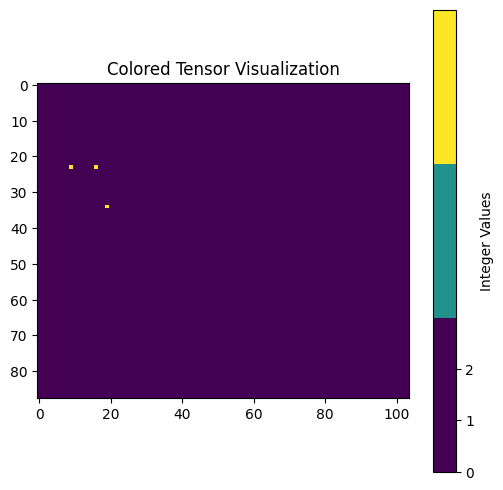

In [15]:
# Plot the tensor
inputs, reconstruction, latents, clusters = predictions[0]

# Get unique values and create a colormap
batch, channels, height, width = inputs.shape
clusters = clusters.argmax(dim=1).view(height, width)
clusters_np = clusters.numpy()
unique_values = np.unique(clusters_np)
colors = plt.cm.get_cmap('viridis', len(unique_values))

# Create a ListedColormap using the unique values
colormap = ListedColormap(colors(np.linspace(0, 1, len(unique_values))))

plt.figure(figsize=(6, 6))
plt.imshow(clusters, cmap=colormap, interpolation='nearest')
plt.colorbar(ticks=range(len(unique_values)), label='Integer Values')
plt.title('Colored Tensor Visualization')
plt.show()

Metric Learning: Introducing a metric learning component, such as triplet loss or contrastive loss, could further encourage within-cluster compactness and between-cluster separation, which can be more effective than variance for certain types of data.

Post-Processing: After training, some post-processing steps like density-based spatial clustering (e.g., DBSCAN) can be applied to the latent representations to refine the cluster assignments and ensure smoothness.

Cluster Number: The number of clusters is fixed at 3 in your current setup. Experimenting with different numbers of clusters or even using techniques to dynamically determine the number of clusters could yield better results.

Your current method for spatial regularization, which penalizes cluster label changes within local neighborhoods, is a creative solution. It resembles the "smoothness" constraint in semi-supervised learning and graph-based clustering, which assumes that points in a small neighborhood are likely to share the same label or cluster assignment. However, ensure that this spatial term is not too strong to overpower the data-driven aspects of the clustering or lead to trivial solutions where the model simply assigns everything to one cluster to minimize the penalty. This balancing act can be delicate and may require careful tuning of your hyperparameters.